<a href="https://colab.research.google.com/github/Syed-Osama-Hussain/Imagined-Speech-Prediction-from-EEG/blob/master/short_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io
import os
from google.colab import drive
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import LSTM, Dropout

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls "drive/My Drive/dataset/Short_words/"

sub_12b_ch64_s_eog_removed_256Hz.mat  sub_5_ch64_s_eog_removed_256Hz.mat
sub_1_ch64_s_eog_removed_256Hz.mat    sub_8g_ch64_s_eog_removed_256Hz.mat
sub_3_ch64_s_eog_removed_256Hz.mat


In [ ]:
mat = scipy.io.loadmat("drive/My Drive/dataset/Short_words/sub_12b_ch64_s_eog_removed_256Hz")
end_trial = mat['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
last_beep = mat['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']

#"Out" during Resting State

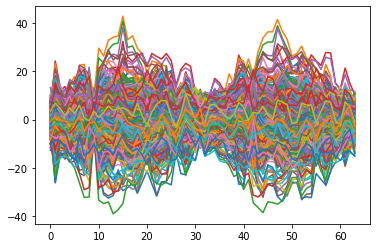

In [ ]:
plt.plot(end_trial[0][0]);

#"In" during Resting State

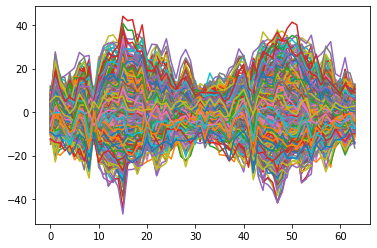

In [ ]:
plt.plot(end_trial[1][0]);

#"Up" during Resting State

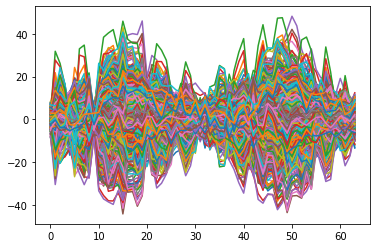

In [ ]:
plt.plot(end_trial[2][0]);

#"Out" during Speech Imagery

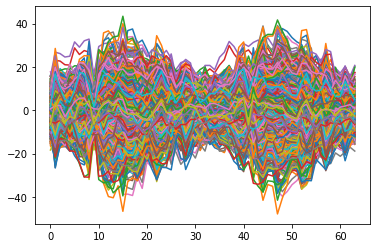

In [ ]:
plt.plot(last_beep[0][0]);

#"In" during Speech Imagery

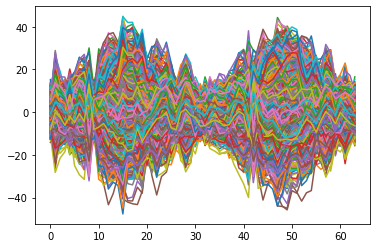

In [ ]:
plt.plot(last_beep[1][0]);

#"Up" during Speech Imagery

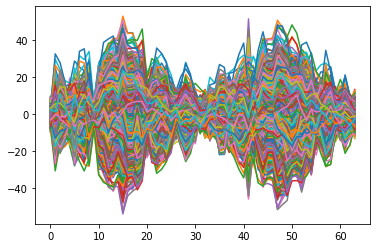

In [ ]:
plt.plot(last_beep[2][0]);

#Covariance Matrix Calculation

In [6]:
def covariance(matrix):
  res_mat = np.matmul(matrix,matrix.transpose())
  return res_mat

#Load Matrices

In [7]:
def loadMatrices(dir):
  matrices_c1 = []
  matrices_c2 = []
  matrices_c3 = []
  for root,sub,files in os.walk(dir):
    for f in sorted(files):
      mat_file  =  scipy.io.loadmat(os.path.join(root, f))
      end_trial = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
      last_beep = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
      matrices_c1.extend([covariance(matrix) for matrix in end_trial[0]])
      matrices_c1.extend([covariance(matrix) for matrix in last_beep[0]])
      matrices_c2.extend([covariance(matrix) for matrix in end_trial[1]])
      matrices_c2.extend([covariance(matrix) for matrix in last_beep[1]])
      matrices_c3.extend([covariance(matrix) for matrix in end_trial[2]])
      matrices_c3.extend([covariance(matrix) for matrix in last_beep[2]])
  return np.concatenate((np.array(matrices_c1),np.array(matrices_c2)),axis=0)
  # return np.concatenate((np.array(matrices_c1),np.array(matrices_c2),np.array(matrices_c3)),axis=0)

#Prepare Data

In [8]:
train_data = loadMatrices("drive/My Drive/dataset/Short_words/")

In [9]:
print(train_data.shape)

(2000, 64, 64)


In [ ]:
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])
train_labels = np.concatenate((np.repeat(x[np.newaxis,:],500,0),np.repeat(y[np.newaxis,:],500,0),np.repeat(z[np.newaxis,:],500,0)),axis=0)
print(train_labels.shape)

(1500, 3)


In [10]:
labels = np.concatenate((np.zeros(1000),np.ones(1000)),axis=0)
# labels = np.concatenate((np.zeros(1000),np.ones(1000),np.full(1000,2)),axis=0)
print(labels)

[0. 0. 0. ... 1. 1. 1.]


In [11]:
from keras.utils.np_utils import to_categorical
# labels = to_categorical(labels, num_classes=3)
labels = to_categorical(labels, num_classes=2)
print(labels.shape,labels)

(2000, 2) [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
print(train_labels)

NameError: ignored

In [12]:

train_data, labels = shuffle(train_data, labels, random_state=0)

divide_percent=(len(train_data)*0.2)
# print(divide_percent,len(train_data))
x_test=train_data[0:int(divide_percent)]
y_test=labels[0:int(divide_percent)]
x_train = train_data[int(divide_percent):len(train_data)]
y_train = labels[int(divide_percent):len(labels)]

In [13]:
print(x_test.shape)
print(x_train.shape)
print(y_test.shape)
print(y_train.shape)

(400, 64, 64)
(1600, 64, 64)
(400, 2)
(1600, 2)


#CNN Model Design

In [ ]:
model=Sequential()

model.add(Conv1D(filters=64, kernel_size=2, activation="relu" , input_shape=(64,64)))
# model.add(MaxPooling1D(pool_size=6))
model.add(Conv1D(filters=64, kernel_size=4, activation="relu", input_shape=(64,64)))
# model.add(MaxPooling1D(pool_size=6))
model.add(Dense(128, activation='relu'))

model.add(Dense(128, activation='relu'))
model.add(Flatten())
# model.add(Dense(2, activation='softmax'))
model.add(Dense(3, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 63, 64)            8256      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 60, 64)            16448     
_________________________________________________________________
dense (Dense)                (None, 60, 128)           8320      
_________________________________________________________________
dense_1 (Dense)              (None, 60, 128)           16512     
_________________________________________________________________
flatten (Flatten)            (None, 7680)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 23043     
Total params: 72,579
Trainable params: 72,579
Non-trainable params: 0
____________________________________________________

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# CNN Training

In [ ]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,verbose=1)

Epoch 1/100
75/75 [==============================] - 0s 6ms/step - loss: 628910.7500 - accuracy: 0.3267 - val_loss: 2009.2998 - val_accuracy: 0.4017
Epoch 2/100
75/75 [==============================] - 0s 4ms/step - loss: 2660984.0000 - accuracy: 0.3350 - val_loss: 2043.8774 - val_accuracy: 0.3267
Epoch 3/100
75/75 [==============================] - 0s 4ms/step - loss: 1722433.8750 - accuracy: 0.3275 - val_loss: 6587.9600 - val_accuracy: 0.3383
Epoch 4/100
75/75 [==============================] - 0s 4ms/step - loss: 357735.5625 - accuracy: 0.3296 - val_loss: 4007.5703 - val_accuracy: 0.3417
Epoch 5/100
75/75 [==============================] - 0s 4ms/step - loss: 104743.8750 - accuracy: 0.3146 - val_loss: 5634.1558 - val_accuracy: 0.2883
Epoch 6/100
75/75 [==============================] - 0s 4ms/step - loss: 33837.4336 - accuracy: 0.3358 - val_loss: 3245.8516 - val_accuracy: 0.3517
Epoch 7/100
75/75 [==============================] - 0s 4ms/step - loss: 59689.0859 - accuracy: 0.3354 - 

#Results

In [ ]:
predictions = model.predict(x_test)
np.round(predictions)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

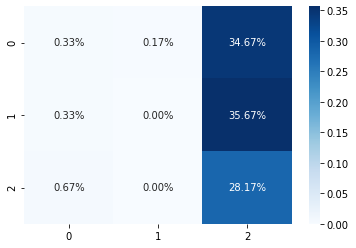

In [ ]:
rounded_labels = np.argmax(y_test, axis=1)
rounded_predictions = np.argmax(predictions, axis=1)
cf = confusion_matrix(rounded_labels,rounded_predictions)  # doctest: +SKIP
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
print(rounded_predictions)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 1 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

In [ ]:
print(rounded_labels)

[2 0 1 0 0 0 1 2 1 0 2 2 2 0 1 2 1 2 1 1 2 2 0 2 0 0 1 0 0 2 1 1 1 1 2 1 0
 0 0 1 2 2 0 0 0 2 2 2 1 2 1 2 0 1 2 1 1 0 0 1 1 0 0 1 2 2 1 1 2 1 1 0 2 2
 1 1 1 1 2 2 2 0 0 1 2 0 0 0 0 1 2 1 1 0 0 1 2 2 0 2 1 1 1 1 1 1 0 1 2 1 2
 2 1 0 0 2 1 2 2 1 2 0 0 1 1 1 2 1 0 1 1 0 0 1 1 2 2 0 2 1 1 0 2 1 2 1 0 2
 1 2 1 0 0 0 1 1 1 1 0 0 1 2 1 0 1 2 0 2 1 0 1 0 1 2 0 0 2 0 0 2 0 0 2 2 0
 2 1 1 2 0 1 0 2 2 2 1 2 1 0 0 1 1 1 1 2 0 0 2 2 1 0 1 2 0 2 0 0 2 1 2 0 1
 0 1 0 1 0 2 1 0 1 0 2 2 1 0 0 0 1 1 0 2 1 0 0 1 0 1 0 2 1 0 1 0 1 2 0 1 1
 2 0 0 2 0 0 2 2 0 0 2 0 0 1 1 1 0 0 0 0 1 1 0 2 2 2 0 2 1 1 1 2 2 0 2 2 0
 1 0 1 2 1 0 1 2 1 0 1 1 1 0 1 2 0 2 1 2 0 0 0 2 0 1 0 0 0 1 0 1 1 0 1 2 0
 1 1 1 2 0 2 1 1 1 0 2 1 2 0 1 1 1 0 2 2 1 2 0 2 1 2 2 2 2 1 1 1 0 1 2 2 2
 0 0 1 0 1 1 0 1 2 1 0 2 0 2 0 0 2 1 0 0 0 2 0 2 2 2 2 0 1 2 2 0 1 0 0 2 0
 1 2 0 0 0 2 1 1 1 1 1 2 0 1 0 1 2 0 0 0 0 1 0 2 2 0 0 2 1 1 1 0 0 2 2 0 0
 1 2 2 2 1 1 2 0 0 0 1 1 0 0 0 1 0 1 1 2 1 1 0 1 2 1 2 2 2 1 0 0 0 2 2 0 1
 2 1 1 1 1 2 0 2 1 0 1 0 

In [ ]:
from keras.layers import LSTM, Dropout

modelRNN = Sequential()
modelRNN.add(LSTM(64,activation="relu",input_shape=(64,64),return_sequences=True))
modelRNN.add(Dense(64, activation='relu'))
modelRNN.add(LSTM(64,activation="relu",return_sequences=True))
modelRNN.add(Dense(64, activation='relu'))
modelRNN.add(LSTM(64,activation="relu"))
modelRNN.add(Dense(64, activation='relu'))
modelRNN.add(Flatten())
modelRNN.add(Dense(3, activation='softmax'))
modelRNN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64, 64)            33024     
_________________________________________________________________
dense_14 (Dense)             (None, 64, 64)            4160      
_________________________________________________________________
lstm_7 (LSTM)                (None, 64, 64)            33024     
_________________________________________________________________
dense_15 (Dense)             (None, 64, 64)            4160      
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
flatten_4 (Flatten)          (None, 64)               

In [ ]:
modelRNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
modelRNN.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,verbose=1)

Epoch 1/100
75/75 [==============================] - 10s 130ms/step - loss: 2253520.7500 - accuracy: 0.3404 - val_loss: 267984.1562 - val_accuracy: 0.3333
Epoch 2/100
75/75 [==============================] - 9s 124ms/step - loss: 493147.6875 - accuracy: 0.3229 - val_loss: 159052.7500 - val_accuracy: 0.3217
Epoch 3/100
75/75 [==============================] - 9s 123ms/step - loss: 303660.6562 - accuracy: 0.3404 - val_loss: 150482.1406 - val_accuracy: 0.3083
Epoch 4/100
75/75 [==============================] - 9s 123ms/step - loss: 291423.3750 - accuracy: 0.3392 - val_loss: 83761.6562 - val_accuracy: 0.3433
Epoch 5/100
75/75 [==============================] - 9s 124ms/step - loss: 507646.8125 - accuracy: 0.3288 - val_loss: 83240.0000 - val_accuracy: 0.3400
Epoch 6/100
75/75 [==============================] - 9s 123ms/step - loss: 145718.8750 - accuracy: 0.3321 - val_loss: 75721.0078 - val_accuracy: 0.3233
Epoch 7/100
75/75 [==============================] - 9s 122ms/step - loss: 65821.50

In [ ]:
predictionsRNN = modelRNN.predict(x_test)
np.round(predictionsRNN)

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

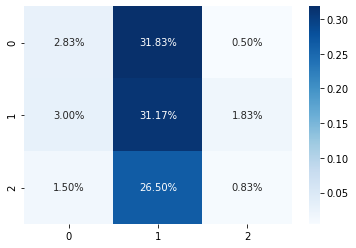

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
rounded_labels = np.argmax(y_test, axis=1)
rounded_predictionsRNN = np.argmax(predictionsRNN, axis=1)
cfRNN = confusion_matrix(rounded_labels,rounded_predictionsRNN)  # doctest: +SKIP
sns.heatmap(cfRNN/np.sum(cfRNN), annot=True, fmt='.2%', cmap='Blues')

In [ ]:
print(rounded_predictionsRNN)

[1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 2 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 1 1 1
 0 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 0 1 1 2 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 

In [ ]:
print(rounded_labels)

[2 0 1 0 0 0 1 2 1 0 2 2 2 0 1 2 1 2 1 1 2 2 0 2 0 0 1 0 0 2 1 1 1 1 2 1 0
 0 0 1 2 2 0 0 0 2 2 2 1 2 1 2 0 1 2 1 1 0 0 1 1 0 0 1 2 2 1 1 2 1 1 0 2 2
 1 1 1 1 2 2 2 0 0 1 2 0 0 0 0 1 2 1 1 0 0 1 2 2 0 2 1 1 1 1 1 1 0 1 2 1 2
 2 1 0 0 2 1 2 2 1 2 0 0 1 1 1 2 1 0 1 1 0 0 1 1 2 2 0 2 1 1 0 2 1 2 1 0 2
 1 2 1 0 0 0 1 1 1 1 0 0 1 2 1 0 1 2 0 2 1 0 1 0 1 2 0 0 2 0 0 2 0 0 2 2 0
 2 1 1 2 0 1 0 2 2 2 1 2 1 0 0 1 1 1 1 2 0 0 2 2 1 0 1 2 0 2 0 0 2 1 2 0 1
 0 1 0 1 0 2 1 0 1 0 2 2 1 0 0 0 1 1 0 2 1 0 0 1 0 1 0 2 1 0 1 0 1 2 0 1 1
 2 0 0 2 0 0 2 2 0 0 2 0 0 1 1 1 0 0 0 0 1 1 0 2 2 2 0 2 1 1 1 2 2 0 2 2 0
 1 0 1 2 1 0 1 2 1 0 1 1 1 0 1 2 0 2 1 2 0 0 0 2 0 1 0 0 0 1 0 1 1 0 1 2 0
 1 1 1 2 0 2 1 1 1 0 2 1 2 0 1 1 1 0 2 2 1 2 0 2 1 2 2 2 2 1 1 1 0 1 2 2 2
 0 0 1 0 1 1 0 1 2 1 0 2 0 2 0 0 2 1 0 0 0 2 0 2 2 2 2 0 1 2 2 0 1 0 0 2 0
 1 2 0 0 0 2 1 1 1 1 1 2 0 1 0 1 2 0 0 0 0 1 0 2 2 0 0 2 1 1 1 0 0 2 2 0 0
 1 2 2 2 1 1 2 0 0 0 1 1 0 0 0 1 0 1 1 2 1 1 0 1 2 1 2 2 2 1 0 0 0 2 2 0 1
 2 1 1 1 1 2 0 2 1 0 1 0 

In [42]:
from keras.layers import Input, Reshape
from keras.layers.merge import concatenate
from keras.models import Model
import keras.backend as K

visible = Input(shape=(64,64))
#CNN
cov1 = Conv1D(filters=64, kernel_size=2, activation="relu")(visible)
# maxpool1 = MaxPooling1D(pool_size=6)(cov1)
cov2 = Conv1D(filters=64, kernel_size=4, activation="relu")(cov1)
# print(K.eval(cov2))
# maxpool2 = MaxPooling1D(pool_size=6)
newShape = Reshape((60,64), name='newReshape')(cov2)
f1 = Flatten()(newShape)
d1 = Dense(128, activation='relu')(f1)
d2 = Dense(128, activation='relu')(d1)

#RNN
lstm1 = LSTM(64,activation="relu",return_sequences=True)(visible)
lstm2 = LSTM(64,activation="relu")(lstm1)
d3 = Dense(64, activation='relu')(lstm2)
d4 = Dense(64, activation='relu')(d3)

merge = concatenate([d2, d4])
encoder1 = Dense(768, activation='relu')(merge)
encoder2 = Dense(96, activation='relu')(encoder1)
decoder1 = Dense(768, activation='relu')(encoder2)
decoder2 = Dense(192, activation='relu')(decoder1)

hidden1 = Dense(64, activation='relu')(encoder2)
hidden2 = Dense(64, activation='relu')(hidden1)
output = Dense(2, activation='softmax')(hidden2)
model = Model(inputs=visible, outputs=output)
print(model.summary())

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 64, 64)]     0                                            
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 63, 64)       8256        input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 60, 64)       16448       conv1d_14[0][0]                  
__________________________________________________________________________________________________
newReshape (Reshape)            (None, 60, 64)       0           conv1d_15[0][0]                  
______________________________________________________________________________________

In [43]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,verbose=1)

Epoch 1/100
50/50 [==============================] - 4s 86ms/step - loss: 8952.7656 - accuracy: 0.4931 - val_loss: 1147285.2500 - val_accuracy: 0.5050
Epoch 2/100
50/50 [==============================] - 4s 80ms/step - loss: 7033.1255 - accuracy: 0.5175 - val_loss: 5403.4971 - val_accuracy: 0.5000
Epoch 3/100
50/50 [==============================] - 4s 80ms/step - loss: 3776.3337 - accuracy: 0.4706 - val_loss: 1009.3184 - val_accuracy: 0.5000
Epoch 4/100
50/50 [==============================] - 4s 79ms/step - loss: 1141.6266 - accuracy: 0.4913 - val_loss: 1180.9948 - val_accuracy: 0.4925
Epoch 5/100
50/50 [==============================] - 4s 80ms/step - loss: 491.1052 - accuracy: 0.4831 - val_loss: 1219.2437 - val_accuracy: 0.5000
Epoch 6/100
50/50 [==============================] - 4s 81ms/step - loss: 434.4501 - accuracy: 0.5181 - val_loss: 299.8401 - val_accuracy: 0.5250
Epoch 7/100
50/50 [==============================] - 4s 83ms/step - loss: 283.5542 - accuracy: 0.4963 - val_loss

In [45]:
predictions = model.predict(x_test)
np.round(predictions)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

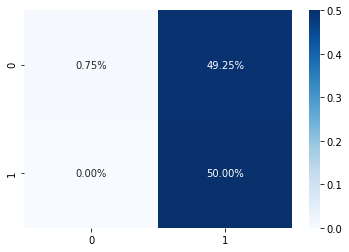

In [46]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
rounded_labels = np.argmax(y_test, axis=1)
rounded_predictions = np.argmax(predictions, axis=1)
cf = confusion_matrix(rounded_labels,rounded_predictions)  # doctest: +SKIP
sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')